In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import torch

In [9]:
simulation_idx = 0
cln025_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-{simulation_idx}-protein/CLN025-{simulation_idx}-CAdistance-mdtraj.pt"
cln025_pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-{simulation_idx}-protein/CLN025-{simulation_idx}-coordinates.pt"

cad_data = torch.load(cln025_cad_path)
pos_data = torch.load(cln025_pos_path)

print(cad_data.shape)
print(pos_data.shape)

torch.Size([530000, 45])
torch.Size([530000, 166, 3])


In [10]:
traj = md.load(
	"/home/shpark/prj-mlcv/lib/DESRES/data/CLN025.pdb"
)
seq_contiguous_resid_pairs = np.array(
	[(r.index, r.index + 1) for r in list(traj.topology.residues)[:-1]]
)
traj.xyz = pos_data.numpy()
traj

<mdtraj.Trajectory with 530000 frames, 166 atoms, 10 residues, without unitcells at 0x7fa89a718070>

# Pseudo

In [11]:
max_ca_seq_distance = 4.5
ca_seq_distances, _ = md.compute_contacts(
	traj, scheme="ca", contacts=seq_contiguous_resid_pairs, periodic=False
)
ca_seq_distances = md.utils.in_units_of(ca_seq_distances, "nanometers", "angstrom")

frames_match_ca_seq_distance = np.all(ca_seq_distances < max_ca_seq_distance, axis=1)

print(f"Number of ca in range: {frames_match_ca_seq_distance.sum()} / {len(traj)}")
print(ca_seq_distances.shape)
print(ca_seq_distances.mean())
print(ca_seq_distances.max())

Number of ca in range: 18447 / 530000
(530000, 9)
3.9850838
6.2864966


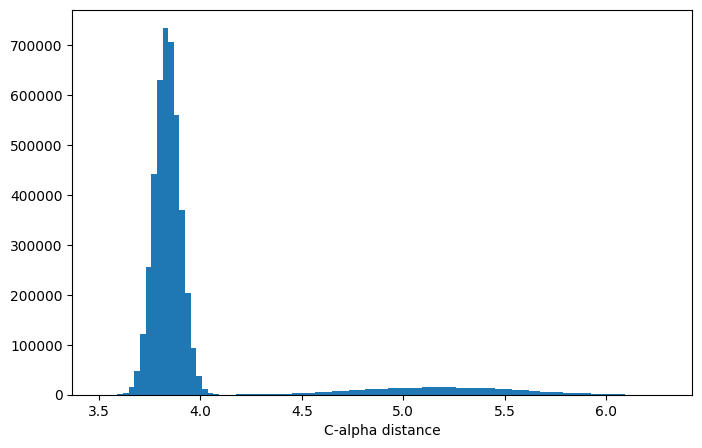

In [12]:
plt.figure(figsize=(8, 5))
plt.xlabel('C-alpha distance')
plt.hist(ca_seq_distances.flatten(), bins=100)
plt.show()

In [13]:
cad_data = torch.load(cln025_cad_path)
print(cad_data.shape)

sequential_idx = [0, 9, 17, 24, 30, 35, 39, 42, 44]
sequential_cad = cad_data[:, sequential_idx]
print(sequential_cad.shape)
print(sequential_cad.mean())
print(sequential_cad.max())


torch.Size([530000, 45])
torch.Size([530000, 9])
tensor(0.3985)
tensor(0.6286)


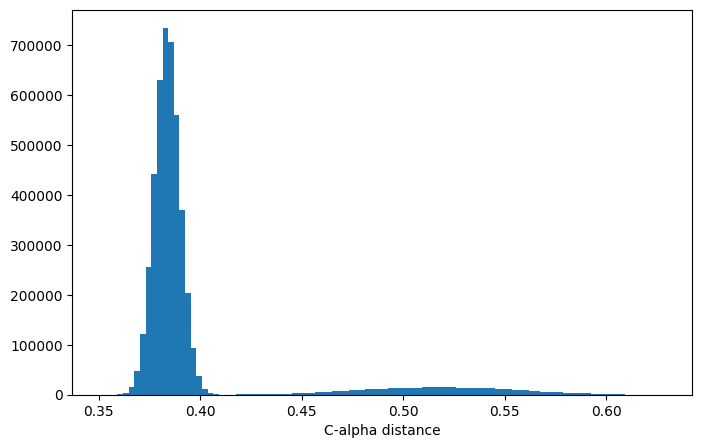

In [14]:
plt.figure(figsize=(8, 5))
plt.xlabel('C-alpha distance')
plt.hist(sequential_cad.flatten(), bins=100)
plt.show()

# BioEmu filter

In [16]:
def _filter_unphysical_traj_masks(
    traj: md.Trajectory,
    max_ca_seq_distance: float = 4.5,
    max_cn_seq_distance: float = 2.0,
    clash_distance: float = 1.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    See `filter_unphysical_traj` for more details.
    """
    # CA-CA residue distance between sequential neighbouring pairs
    seq_contiguous_resid_pairs = np.array(
        [(r.index, r.index + 1) for r in list(traj.topology.residues)[:-1]]
    )

    ca_seq_distances, _ = md.compute_contacts(
        traj, scheme="ca", contacts=seq_contiguous_resid_pairs, periodic=False
    )
    ca_seq_distances = md.utils.in_units_of(ca_seq_distances, "nanometers", "angstrom")

    frames_match_ca_seq_distance = np.all(ca_seq_distances < max_ca_seq_distance, axis=1)

    # C-N distance between sequential neighbouring pairs
    cn_atom_pair_indices: list[tuple[int, int]] = []

    for resid_i, resid_j in seq_contiguous_resid_pairs:
        residue_i, residue_j = (
            traj.topology.residue(resid_i),
            traj.topology.residue(resid_j),
        )
        c_i, n_j = (
            list(residue_i.atoms_by_name("C")),
            list(residue_j.atoms_by_name("N")),
        )
        assert len(c_i) == len(n_j) == 1
        cn_atom_pair_indices.append((c_i[0].index, n_j[0].index))

    assert cn_atom_pair_indices

    cn_seq_distances = md.compute_distances(traj, cn_atom_pair_indices, periodic=False)
    cn_seq_distances = md.utils.in_units_of(cn_seq_distances, "nanometers", "angstrom")

    frames_match_cn_seq_distance = np.all(cn_seq_distances < max_cn_seq_distance, axis=1)

    # Clashes between any two atoms from different residues
    rest_distances, _ = md.compute_contacts(traj, periodic=False)
    frames_non_clash = np.all(
        md.utils.in_units_of(rest_distances, "nanometers", "angstrom") > clash_distance,
        axis=1,
    )
    
    # Print stats
    print(f"Number of frames: {len(traj)}")
    print(f"Average CA-CA distance: {ca_seq_distances.mean()}")
    print(f"Average C-N distance: {cn_seq_distances.mean()}")
    print(f"Average clash distance: {rest_distances.mean()}")
    return frames_match_ca_seq_distance, frames_match_cn_seq_distance, frames_non_clash

In [17]:
ca, cn, clash = _filter_unphysical_traj_masks(traj)

Number of frames: 530000
Average CA-CA distance: 3.985083818435669
Average C-N distance: 1.5783789157867432
Average clash distance: 0.5994189381599426
